In [23]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

from src.accelerometer import plot_fourier_transformation, plot_acceleration, plot_feature_columns, box_plot_acceleration, accelerometer_feature_engineering
from src.kmeans import kmeans
from src.principal_component_analysis import principal_component_analysis, plot_principal_component_analysis
from src.decision_tree import decision_tree

In [24]:
slow_move_df = pd.read_csv('slow_moves.csv')
slow_move_df = slow_move_df[slow_move_df['age_group']!=0]

In [25]:
slow_move_df.head(5)

,subject,age_group,file,uuid,hand,device,duration,time_stamp,x,y,z,mag
217,50-03,50,c3f64314-9387-4b05-90af-c60d224bd23f.json,c3f64314-9387-4b05-90af-c60d224bd23f,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,125,1670852909113,-82,-364,3354,3374.690504
218,50-03,50,c3f64314-9387-4b05-90af-c60d224bd23f.json,c3f64314-9387-4b05-90af-c60d224bd23f,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,183,1670852909171,-86,-364,3370,3390.691965
219,50-03,50,c3f64314-9387-4b05-90af-c60d224bd23f.json,c3f64314-9387-4b05-90af-c60d224bd23f,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,212,1670852909200,-56,-370,3334,3354.935469
220,50-03,50,c3f64314-9387-4b05-90af-c60d224bd23f.json,c3f64314-9387-4b05-90af-c60d224bd23f,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,242,1670852909230,-82,-368,3392,3412.889099
221,50-03,50,c3f64314-9387-4b05-90af-c60d224bd23f.json,c3f64314-9387-4b05-90af-c60d224bd23f,dominant,C1C0369D-9684-B08A-4B55-12AD667E37FE,273,1670852909261,-88,-138,3366,3369.976855


In [26]:
slow_move_df.describe()

,age_group,duration,time_stamp,x,y,z,mag
count,8399.000000,8399.000000,8.399000e+03,8399.000000,8399.000000,8399.000000,8399.000000
mean,36.053102,3107.072747,1.670920e+12,615.133230,319.881176,3200.432432,3453.039130
std,9.188691,2254.209095,1.414007e+08,824.316238,677.444059,313.492581,191.216629
min,30.000000,106.000000,1.670579e+12,-1678.000000,-3456.000000,644.000000,2900.596490
25%,30.000000,1186.500000,1.670954e+12,20.000000,117.000000,3066.000000,3360.407116
50%,30.000000,2580.000000,1.670959e+12,614.000000,356.000000,3338.000000,3464.107389
75%,50.000000,4705.500000,1.671033e+12,1224.000000,762.000000,3384.000000,3581.209851
max,50.000000,9259.000000,1.671034e+12,2382.000000,1148.000000,3910.000000,3944.572981


In [27]:
single_session_df = slow_move_df[slow_move_df['uuid'] == slow_move_df['uuid'].unique()[0]]

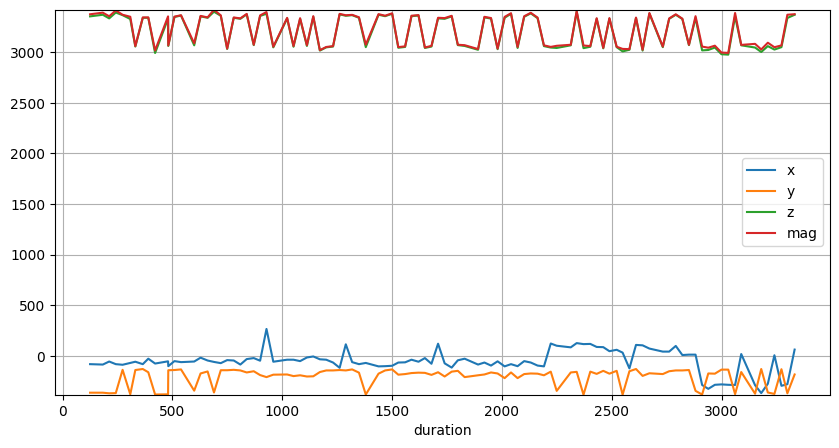

In [28]:
plot_acceleration(single_session_df, subplots=False)

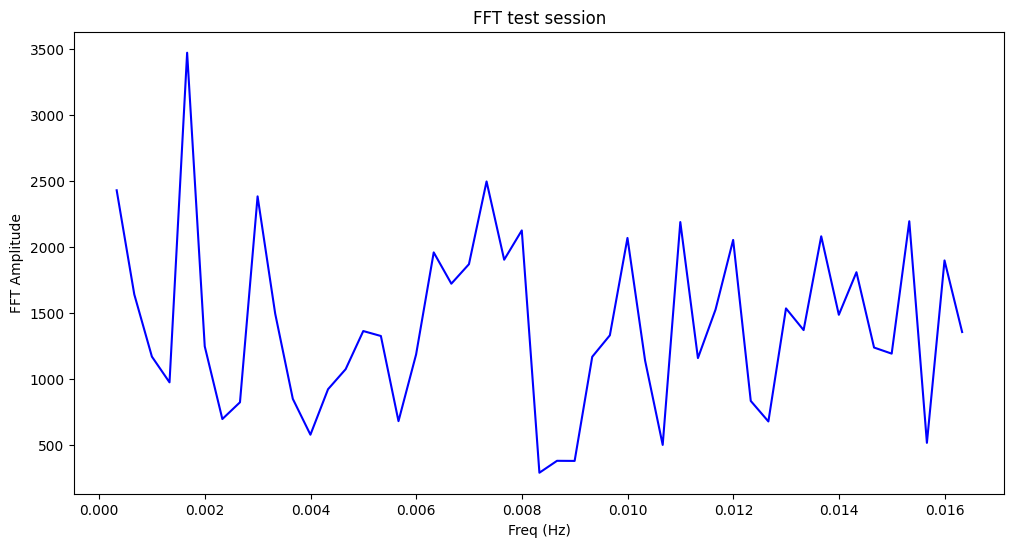

In [29]:
plot_fourier_transformation(single_session_df, 'test session')

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/accelerometer.py:201: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = df.groupby(['device'])['x', 'y', 'z', 'mag']


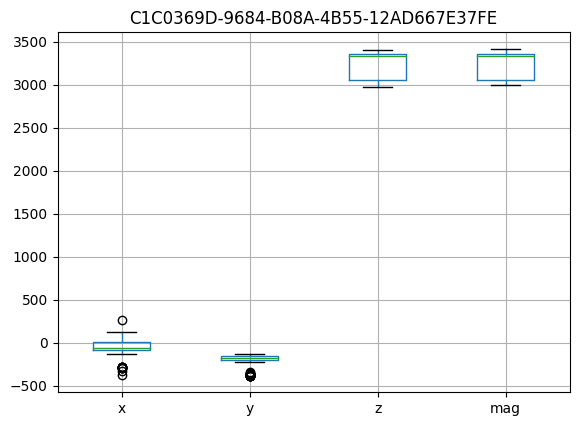

In [30]:
box_plot_acceleration(single_session_df)

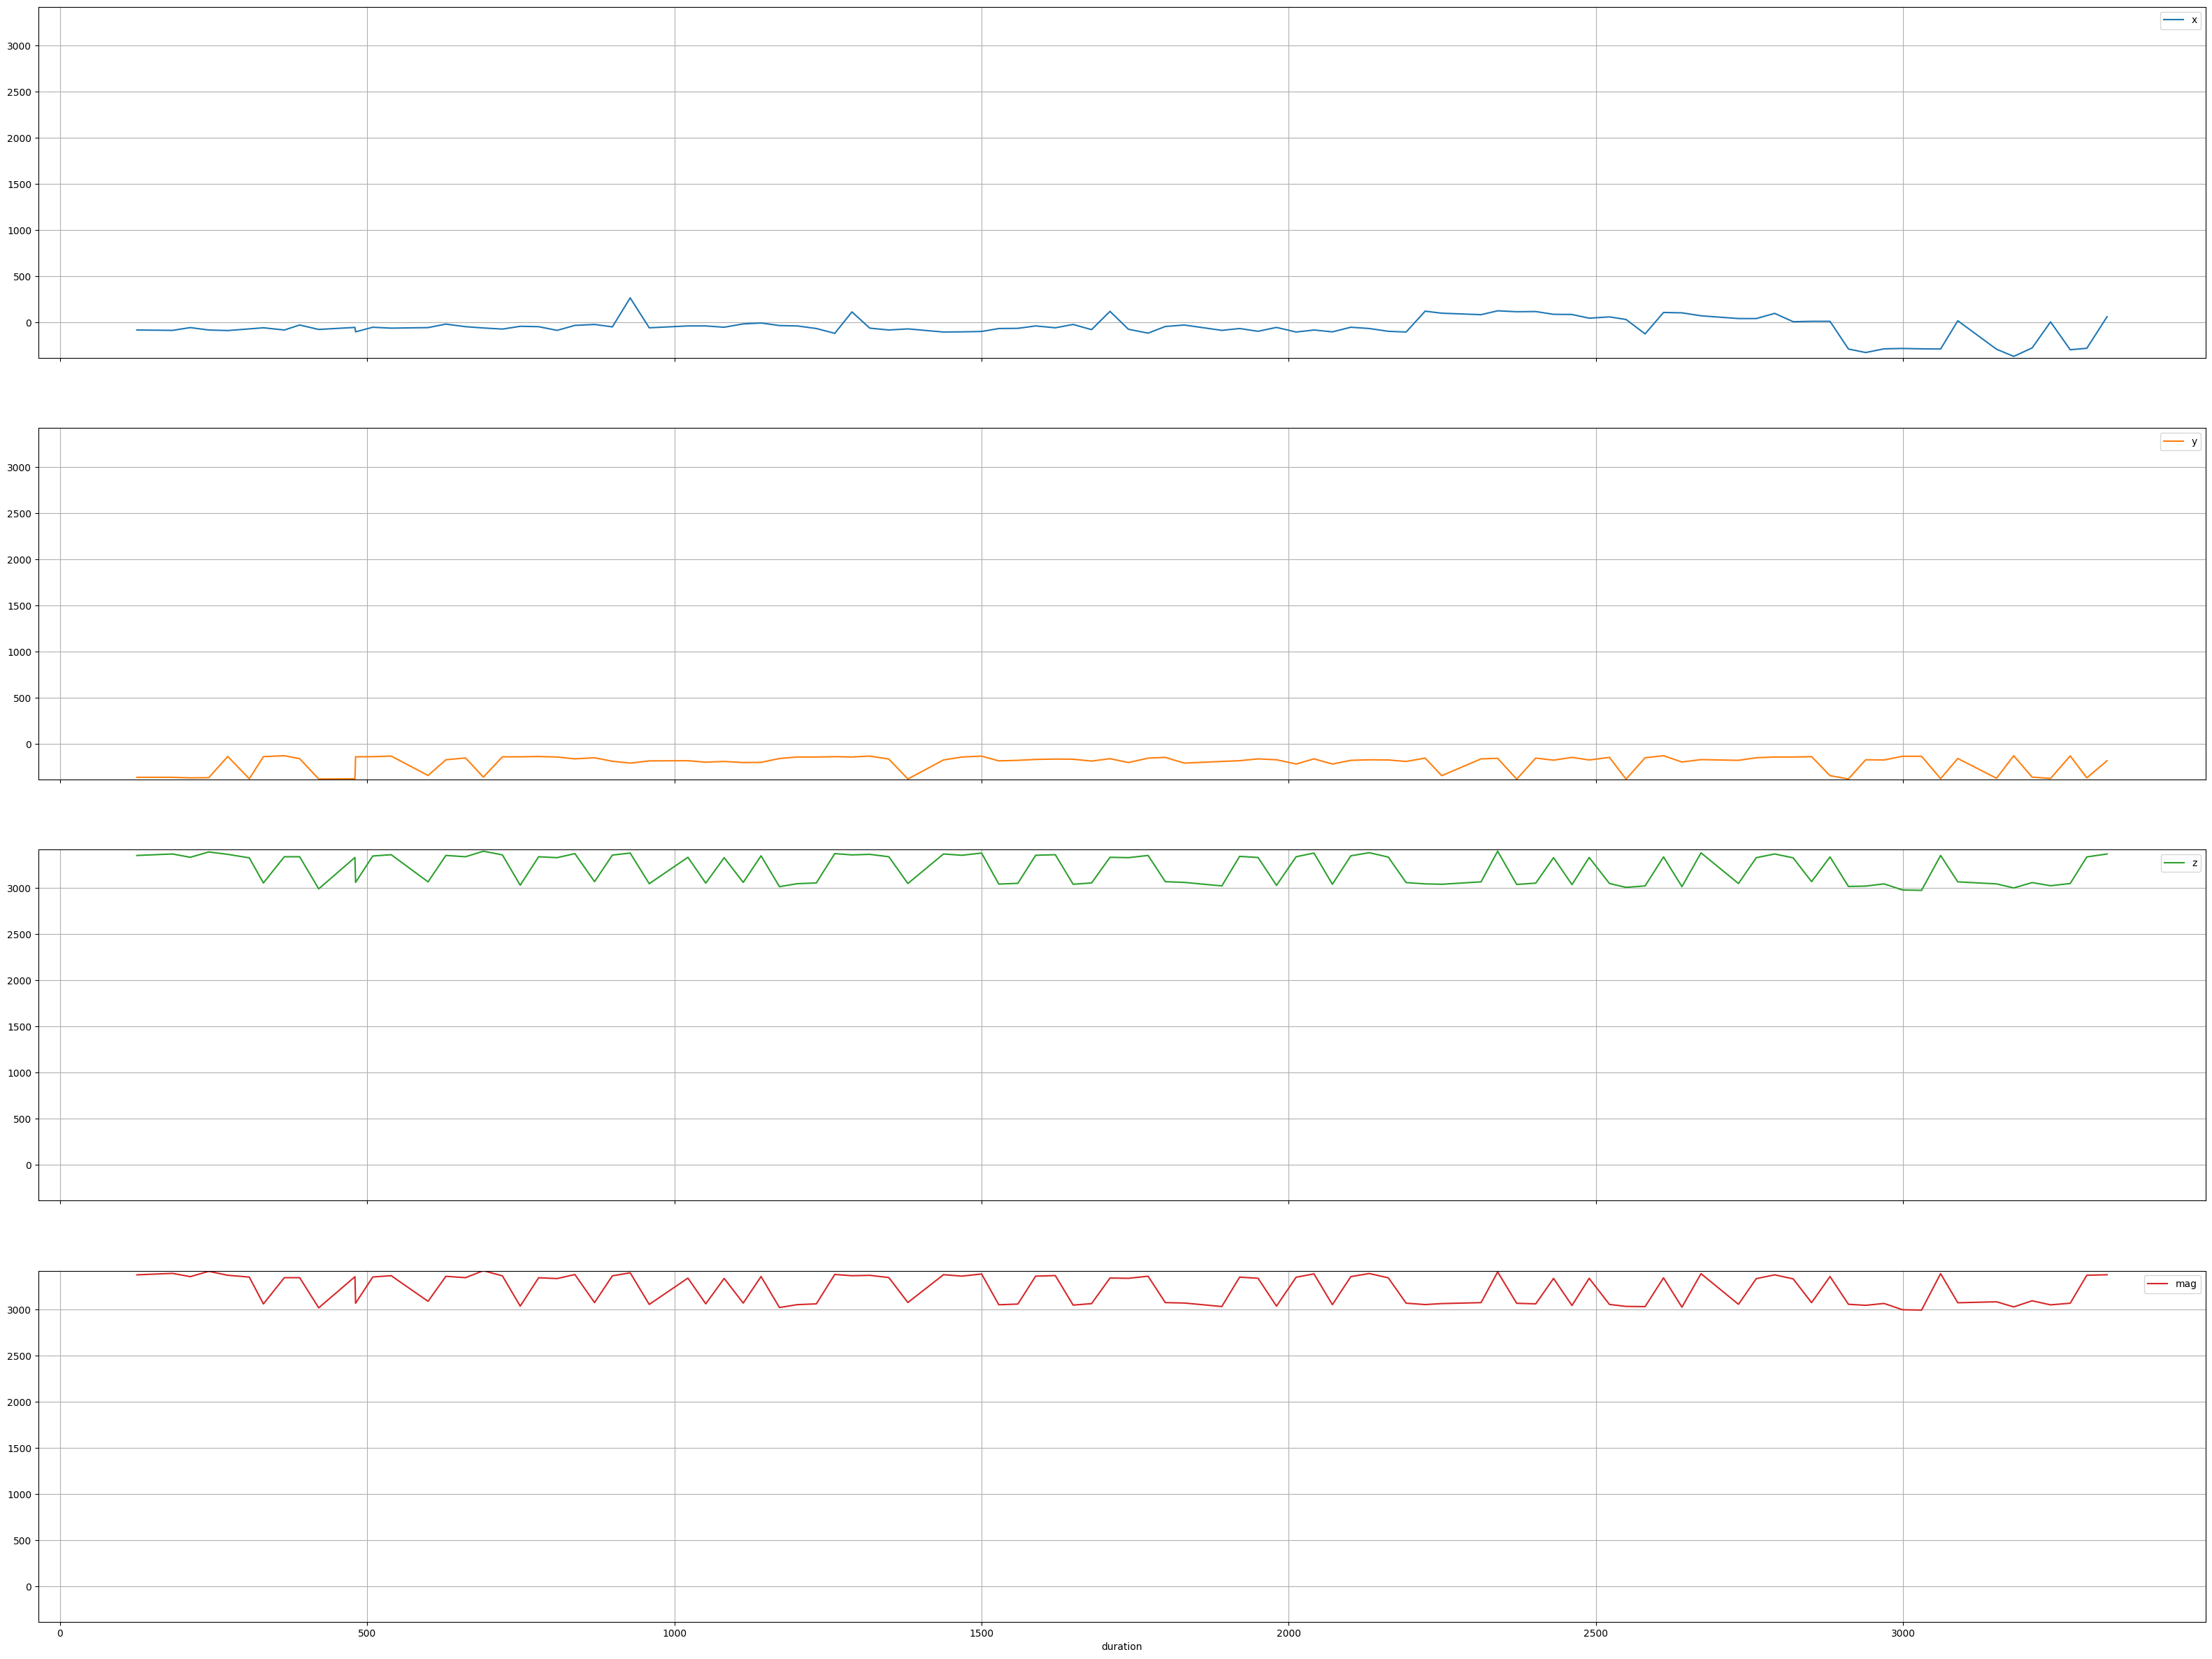

In [31]:
plot_acceleration(single_session_df)

In [32]:
slow_move_processed_df = accelerometer_feature_engineering(slow_move_df)

In [33]:
slow_move_processed_df.head()

x_std  \
age_group subject device                               hand     uuid                                               
30        30-02   C1C0369D-9684-B08A-4B55-12AD667E37FE dominant 37a13ab3-e60f-4838-83e9-da532a39831a  102.697673   
                                                                58d157db-0aec-489c-8df0-41414c91cef9  128.976062   
                                                                658f8d78-51df-4e81-841f-3c2dd8ee828b  104.850669   
                                                                87b711b8-6c4d-41c6-9963-462f52fafc35  182.740397   
                                                                fd4495be-6dce-43b3-b8c4-bcdc5d8cdf87  115.997833   

                                                                                                           y_std  \
age_group subject device                               hand     uuid                                               
30        30-02   C1C0369D-9684-B08A-4B55-12AD667E37FE dominant 37a13ab3-e60f-4838-83e9-da532a39831a  166.894644   
                                                                58d157db-0aec-489c-8df0-41414c91cef9  154.705577   
                                                                658f8d78-51df-4e81-841f-3c2dd8ee828b  131.775506   
                                                                87b711b8-6c4d-41c6-9963-462f52fafc35  147.136685   
                                                                fd4495be-6dce-43b3-b8c4-bcdc5d8cdf87  148.596584   

                                                                                                           z_std  \
age_group subject device                               hand     uuid                                               
30        30-02   C1C0369D-9684-B08A-4B55-12AD667E37FE dominant 37a13ab3-e60f-4838-83e9-da532a39831a  160.648295   
                                                                58d157db-0aec-489c-8df0-41414c91cef9  176.512755   
                                                                658f8d78-51df-4e81-841f-3c2dd8ee828b  165.761434   
                                                                87b711b8-6c4d-41c6-9963-462f52fafc35  172.332214   
                                                                fd4495be-6dce-43b3-b8c4-bcdc5d8cdf87  153.302611   

                                                                                                         mag_std  \
age_group subject device                               hand     uuid                                               
30        30-02   C1C0369D-9684-B08A-4B55-12AD667E37FE dominant 37a13ab3-e60f-4838-83e9-da532a39831a  164.757063   
                                                                58d157db-0aec-489c-8df0-41414c91cef9  171.970307   
                                                                658f8d78-51df-4e81-841f-3c2dd8ee828b  154.467180   
                                                                87b711b8-6c4d-41c6-9963-462f52fafc35  155.755503   
                                                                fd4495be-6dce-43b3-b8c4-bcdc5d8cdf87  139.193670   

                                                                                                           x_mean  \
age_group subject device                               hand     uuid                                                
30        30-02   C1C0369D-9684-B08A-4B55-12AD667E37FE dominant 37a13ab3-e60f-4838-83e9-da532a39831a  1285.789474   
                                                                58d157db-0aec-489c-8df0-41414c91cef9  1279.820513   
                                                                658f8d78-51df-4e81-841f-3c2dd8ee828b  1294.225352   
                                                                87b711b8-6c4d-41c6-9963-462f52fafc35  1370.355556   
                                                                fd4495be-6dce-43b3-b8c4-bcdc5d8cdf87  1295.833333   

                                   

In [34]:
slow_move_processed_df.corr()

,x_std,y_std,z_std,mag_std,x_mean,y_mean,z_mean,mag_mean,x_sem,y_sem,...,mag_peaks,x_sal,y_sal,z_sal,mag_sal,duration,x_snr,y_snr,z_snr,mag_snr
x_std,1.000000,0.412217,0.098803,0.148158,-0.411439,-0.082512,0.047705,-0.389548,0.604503,0.233110,...,-0.040395,0.099604,-0.201002,0.186459,0.092268,-0.031948,-0.462169,0.165540,-0.000110,-0.283585
y_std,0.412217,1.000000,0.187160,0.270302,-0.200627,0.073459,0.205444,-0.330170,0.416989,0.712972,...,-0.230959,-0.002907,-0.323913,-0.125921,-0.163294,-0.230018,-0.173945,0.210799,-0.003114,-0.372929
z_std,0.098803,0.187160,1.000000,0.944449,-0.129801,0.024692,0.069121,-0.418235,0.243641,0.297890,...,-0.340049,-0.116859,-0.041770,0.018761,-0.061346,-0.317330,-0.021204,0.212776,-0.823985,-0.650489
mag_std,0.148158,0.270302,0.944449,1.000000,-0.076297,0.160103,0.280203,-0.429161,0.290833,0.361035,...,-0.342278,-0.149267,-0.072177,-0.003201,-0.067963,-0.322610,0.016136,0.387254,-0.661016,-0.797883
x_mean,-0.411439,-0.200627,-0.129801,-0.076297,1.000000,0.350484,0.292093,0.868309,-0.239006,-0.060662,...,0.058502,0.282839,0.168724,-0.025806,0.119294,0.053928,0.955695,0.272933,0.259158,-0.014784
y_mean,-0.082512,0.073459,0.024692,0.160103,0.350484,1.000000,0.642141,0.240967,-0.126508,-0.005986,...,0.173982,0.140242,0.154187,-0.026548,-0.039153,0.172093,0.404878,0.815299,0.311923,-0.491796
z_mean,0.047705,0.205444,0.069121,0.280203,0.292093,0.642141,1.000000,0.030230,-0.040446,0.054781,...,0.183806,-0.125344,-0.184881,0.047853,0.073257,0.186631,0.314375,0.847712,0.473891,-0.695095
mag_mean,-0.389548,-0.330170,-0.418235,-0.429161,0.868309,0.240967,0.030230,1.000000,-0.357576,-0.252669,...,0.203047,0.340205,0.226926,0.059915,0.181889,0.192039,0.780199,0.022061,0.361854,0.352404
x_sem,0.604503,0.416989,0.243641,0.290833,-0.239006,-0.126508,-0.040446,-0.357576,1.000000,0.787801,...,-0.719959,0.152552,-0.022149,-0.217356,-0.322337,-0.722988,-0.249512,0.033353,-0.237939,-0.269946
y_sem,0.233110,0.712972,0.297890,0.361035,-0.060662,-0.005986,0.054781,-0.252669,0.787801,1.000000,...,-0.759348,0.092937,-0.063082,-0.364381,-0.418854,-0.766615,-0.017521,0.095087,-0.237913,-0.329397


SEM is closely related to std -> therefore we drop it

In [35]:
slow_move_processed_df = slow_move_processed_df.drop(columns=['x_sem', 'y_sem', 'z_sem', 'mag_sem'])
slow_move_processed_df.corr()

,x_std,y_std,z_std,mag_std,x_mean,y_mean,z_mean,mag_mean,x_peaks,y_peaks,...,mag_peaks,x_sal,y_sal,z_sal,mag_sal,duration,x_snr,y_snr,z_snr,mag_snr
x_std,1.000000,0.412217,0.098803,0.148158,-0.411439,-0.082512,0.047705,-0.389548,-0.044019,-0.025433,...,-0.040395,0.099604,-0.201002,0.186459,0.092268,-0.031948,-0.462169,0.165540,-0.000110,-0.283585
y_std,0.412217,1.000000,0.187160,0.270302,-0.200627,0.073459,0.205444,-0.330170,-0.228794,-0.247486,...,-0.230959,-0.002907,-0.323913,-0.125921,-0.163294,-0.230018,-0.173945,0.210799,-0.003114,-0.372929
z_std,0.098803,0.187160,1.000000,0.944449,-0.129801,0.024692,0.069121,-0.418235,-0.345836,-0.322462,...,-0.340049,-0.116859,-0.041770,0.018761,-0.061346,-0.317330,-0.021204,0.212776,-0.823985,-0.650489
mag_std,0.148158,0.270302,0.944449,1.000000,-0.076297,0.160103,0.280203,-0.429161,-0.346990,-0.320925,...,-0.342278,-0.149267,-0.072177,-0.003201,-0.067963,-0.322610,0.016136,0.387254,-0.661016,-0.797883
x_mean,-0.411439,-0.200627,-0.129801,-0.076297,1.000000,0.350484,0.292093,0.868309,0.070349,0.026218,...,0.058502,0.282839,0.168724,-0.025806,0.119294,0.053928,0.955695,0.272933,0.259158,-0.014784
y_mean,-0.082512,0.073459,0.024692,0.160103,0.350484,1.000000,0.642141,0.240967,0.195527,0.200498,...,0.173982,0.140242,0.154187,-0.026548,-0.039153,0.172093,0.404878,0.815299,0.311923,-0.491796
z_mean,0.047705,0.205444,0.069121,0.280203,0.292093,0.642141,1.000000,0.030230,0.185399,0.200710,...,0.183806,-0.125344,-0.184881,0.047853,0.073257,0.186631,0.314375,0.847712,0.473891,-0.695095
mag_mean,-0.389548,-0.330170,-0.418235,-0.429161,0.868309,0.240967,0.030230,1.000000,0.218046,0.179937,...,0.203047,0.340205,0.226926,0.059915,0.181889,0.192039,0.780199,0.022061,0.361854,0.352404
x_peaks,-0.044019,-0.228794,-0.345836,-0.346990,0.070349,0.195527,0.185399,0.218046,1.000000,0.987066,...,0.992612,-0.107457,-0.151721,0.409146,0.435721,0.992169,0.043357,0.164360,0.427939,0.120668
y_peaks,-0.025433,-0.247486,-0.322462,-0.320925,0.026218,0.200498,0.200710,0.179937,0.987066,1.000000,...,0.988683,-0.105387,-0.156467,0.403415,0.424464,0.990391,0.001859,0.167829,0.413253,0.101289


In [36]:
feature_keys = ['x_std','y_std','z_std','mag_std','x_mean','y_mean','z_mean','mag_mean','x_peaks','y_peaks','z_peaks','mag_peaks','x_snr','y_snr','z_snr','mag_snr', 'x_sal','y_sal','z_sal','mag_sal','duration']
class_key = ['age_group']

/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/accelerometer.py:198: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df_grouped.boxplot(fontsize=20, ax=ax)
/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/accelerometer.py:198: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df_grouped.boxplot(fontsize=20, ax=ax)
/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/accelerometer.py:198: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df_grouped.boxplot(fontsize=20, ax=ax)
/Users/timo/Documents/code/fhnw/master_thesis_analysis/src/accelerometer.py:198: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df_grouped.boxplot(fontsize=20, ax=ax)
/Users/timo/

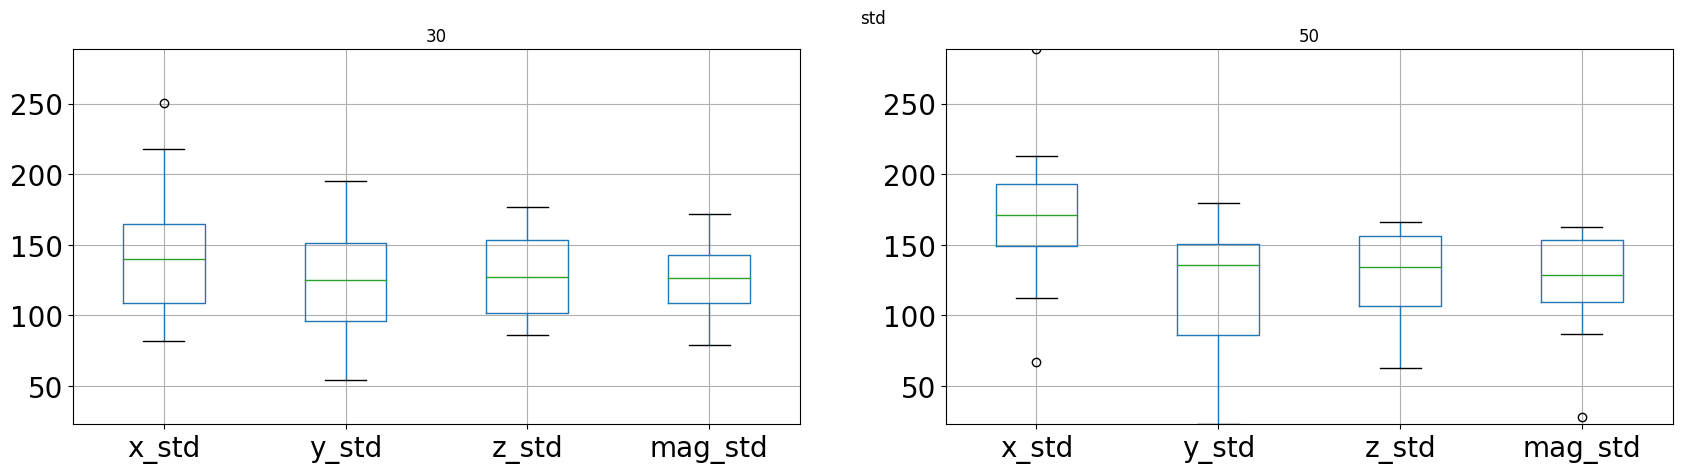

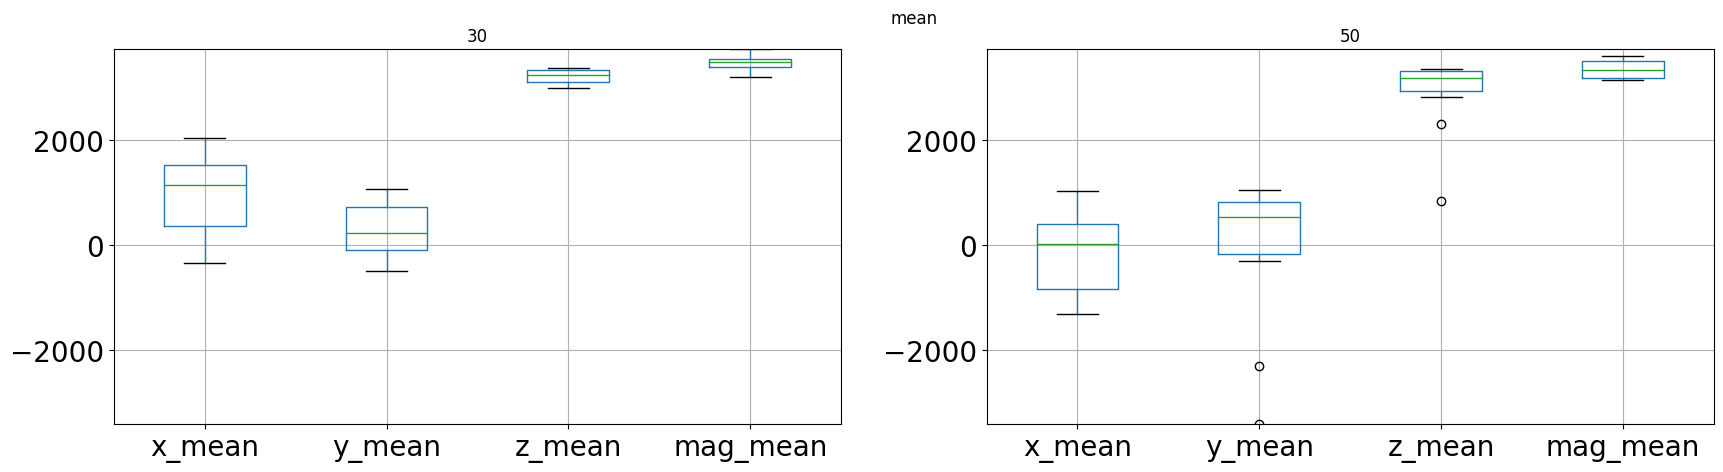

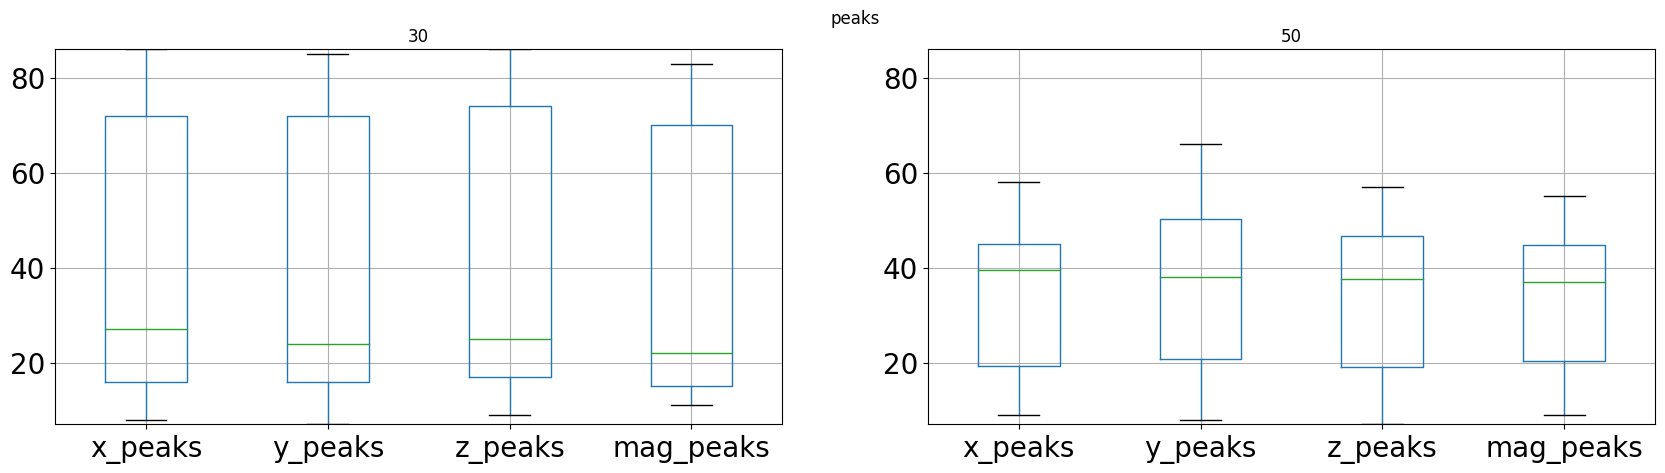

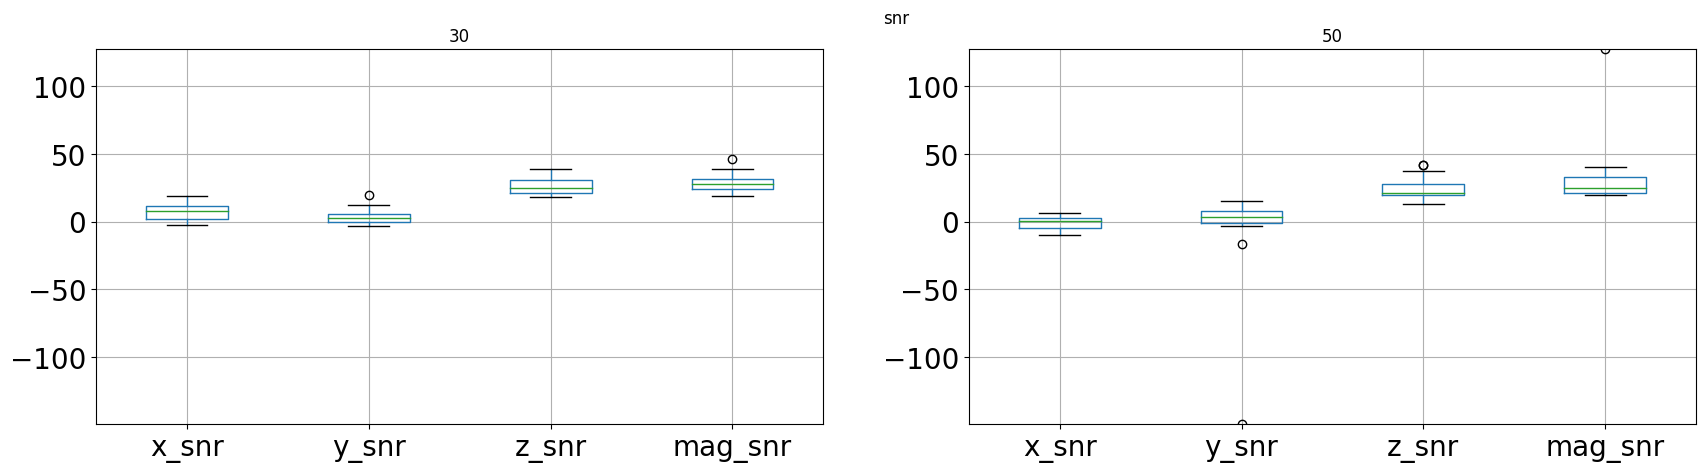

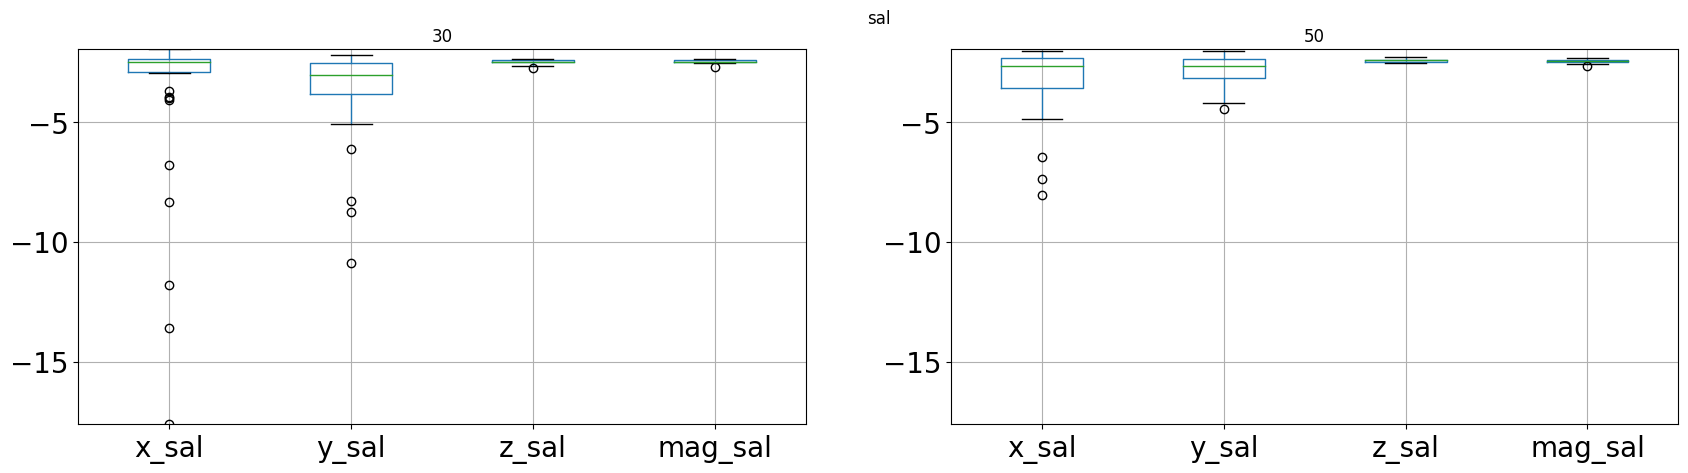

In [37]:
plot_feature_columns(slow_move_processed_df,class_key,'std')
plot_feature_columns(slow_move_processed_df,class_key,'mean')
plot_feature_columns(slow_move_processed_df,class_key,'peaks')
plot_feature_columns(slow_move_processed_df,class_key,'snr')
plot_feature_columns(slow_move_processed_df,class_key,'sal')

We can see that there is no significant deviation between the two age groups in the following features:
- y_mean
- mag_mean
- z_snr
- mag_snr
- z_sal
- mag_sal

In [38]:
slow_move_processed_df = slow_move_processed_df.reset_index(drop=False)
train_df, test_df = train_test_split(slow_move_processed_df, test_size=0.10)

In [39]:
feature_keys = ['x_std','z_std', 'z_std','mag_std','x_mean','y_mean','x_peaks','y_peaks','z_peaks','mag_peaks','x_snr','y_snr','x_sal','y_sal']

# Apply Kmeans Clustering

In [40]:
kmeans_model = kmeans(train_df, feature_keys)
kmeans_predicitons = kmeans_model.predict(test_df[feature_keys])
predictions_df = pd.DataFrame()
predictions_df['age_group'] = test_df['age_group']
predictions_df['cluster'] = kmeans_predicitons
predictions_df

,age_group,cluster
44,50,1
33,30,0
58,50,0
35,30,0
47,50,1
10,30,0
46,50,1


# Principal Component Analysis

In [41]:
principal_components_df = principal_component_analysis(slow_move_processed_df, feature_keys)

<Figure size 640x480 with 0 Axes>

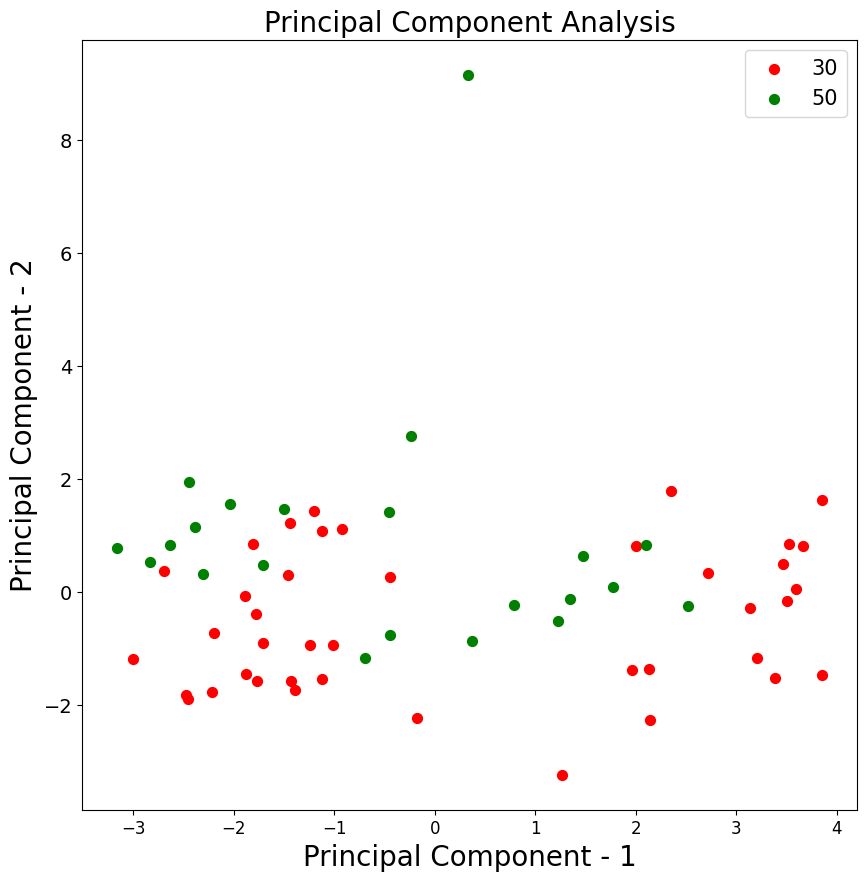

In [42]:
plot_principal_component_analysis(slow_move_processed_df, principal_components_df, 'age_group', [30,50])

# Decision Tree

In [43]:
dt = decision_tree(train_df, feature_keys)

In [44]:
dt_predictions = dt.predict(test_df[feature_keys])
metrics.accuracy_score(test_df['age_group'], dt_predictions)

0.7142857142857143